# Task 4: PID Controller

In this notebook, we will implement a PID controller and use it to control a spring-mass system.

## Imports

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint

## Implementing the PID Controller

**Task:** Implement your PID controller in the *PIDController* class.

In [4]:
class PIDController:
    ### Your code here ###
    def __init__(self, Kp, Ki, Kp_derivative, dt, output_limits=(None, None)):
        """
        Kp: proportional gain
        Ki: integral gain
        Kd: derivative gain
        dt: sampling time
        output_limits: (min, max) limit for the controller output
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kp_derivative
        self.dt = dt

        self.integral = 0.0
        self.prev_error = 0.0
        self.output_limits = output_limits

    def reset(self):
        """Reset integral and derivative state."""
        self.integral = 0.0
        self.prev_error = 0.0

    def __call__(self, error):
        """
        Compute PID control signal given the error.
        This allows the object to be called like a function.
        """
        # Integral term
        self.integral += error * self.dt

        # Derivative term
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error

        # PID output
        u = (
            self.Kp * error +
            self.Ki * self.integral +
            self.Kd * derivative
        )

        # Apply output limits
        u_min, u_max = self.output_limits
        if u_min is not None:
            u = max(u_min, u)
        if u_max is not None:
            u = min(u_max, u)

        return u
    ###

## Controlling a Spring-Mass System

In this task, we want to use the PID controller we have implemented above to control the spring-mass system with friction that is depicted in the figure below:

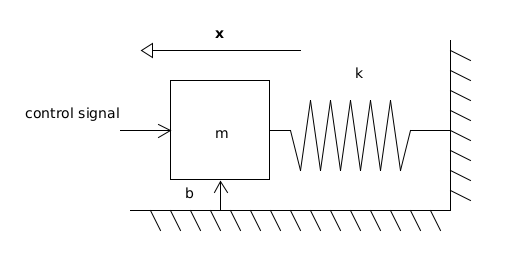  

Our system consists of a body with mass *m*, that glides over the floor with a friction coefficient of *b*, and a spring with Hook's contant *k*. For the sake of simplicity, we assume that the there is no difference between static and dynamic friction. In this task, we want to use our PID controller to keep the body at a constant position x_goal by using it to apply a force (*control dignal*) to the body.  
The dynamics of that system are already implemented in the *SpringMassSystem* class below.

In [5]:
class SpringMassSystem:
    def __init__(self, m, b, k, x_0, dx_0, ddx_0):
        self.m = m
        self.b = b
        self.k = k
        # initial state
        self.x = x_0
        self.dx = dx_0
        self.ddx = ddx_0

        self.control_signal = 0

    def step(self, state, t):
        self.x = state[0]
        self.dx = state[1]
        self.ddx = -1 * ((self.b/self.m)*self.dx + (self.k/self.m)*self.x - self.control_signal/self.m)
        return [self.dx, self.ddx]

    def set_control_signal(self, signal):
        self.control_signal = signal

We start by initialising our spring-mass system.

In [6]:
# mass, friction coefficient, and Hooke's constant
m = 0.5
b = 0.01
k = 4

# initial state
x0 = -1.0
dx0 = 0
ddx0 = 0

# goal position
x_goal = 0.5

# timestep in seconds
dt = 0.1

# initialising the system
sms = SpringMassSystem(m,b,k,x0,dx0,ddx0)

**Task:** Initialise your PID controller.

In [7]:
### Your code here

# pid_controller = PIDController(Kp=20.0, Ki=2.0, Kp_derivative=3.0, dt=dt)

pid_controller = PIDController(
    Kp=20.0,
    Ki=2.0,
    Kp_derivative=3.0,
    dt=dt,
    output_limits=(-20, 20)
)
###

Now, we simulate the system for 600 timesteps (60 seconds).  
**Task:** Apply your PID controller to the spring-mass system.

In [14]:
state = [[x0, dx0]]
states = [np.array([x0, dx0])]

t = np.array([0, 0.1])
ts = [0]
xs = [x0]
dxs = [dx0]
ddxs = [0]
control_signals = [0]

# FIX: initialize control signal BEFORE first odeint call
sms.set_control_signal(0)

for i in range(600):
    state = odeint(sms.step, state[-1], t)
    states.append(state[-1])
    x_t = state[-1][0]
    dx_t = state[-1][1]
    ddx_t = sms.ddx

    ### Your code here
    error = x_goal - x_t
    control_signal = pid_controller(error)
    ###
    
    sms.set_control_signal(control_signal)
    control_signals.append(control_signal)
    
    ts.append(t[-1])
    xs.append(x_t)
    dxs.append(dx_t)
    ddxs.append(ddx_t)
    
    t = t + dt


Finally, we plot the system behaviour, to see how well our PID controler has performed.

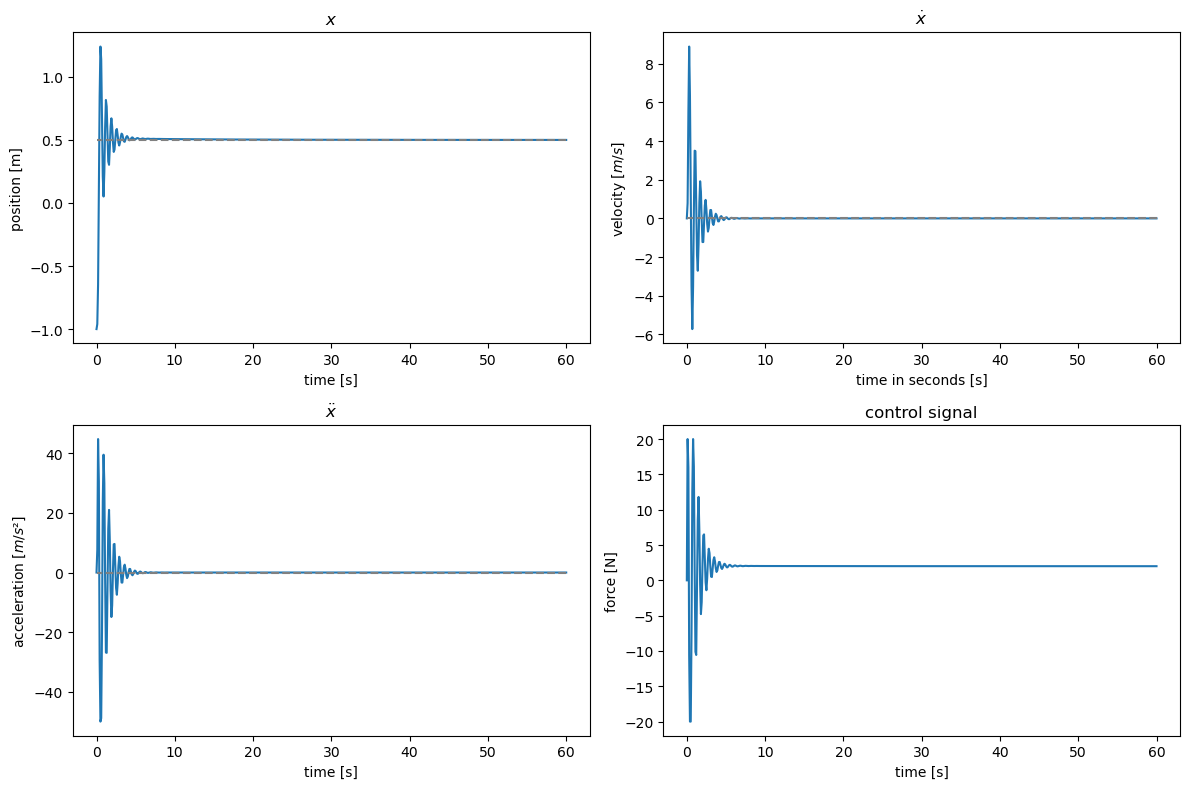

In [15]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes[0,0].plot(ts, xs)
axes[0,0].hlines(x_goal, 60, 0, color="gray", ls="--")
axes[0,0].set_title("$x$")
axes[0,0].set_xlabel("time [s]")
axes[0,0].set_ylabel("position [m]")

axes[0,1].plot(ts, dxs)
axes[0,1].set_title("$\dot{x}$")
axes[0,1].hlines(0, 60, 0, color="gray", ls="--")
axes[0,1].set_xlabel("time in seconds [s]")
axes[0,1].set_ylabel("velocity [$m/s$]")

axes[1,0].plot(ts, ddxs)
axes[1,0].set_title("$\ddot{x}$")
axes[1,0].hlines(0, 60, 0, color="gray", ls="--")
axes[1,0].set_xlabel("time [s]")
axes[1,0].set_ylabel("acceleration [$m/s²$]")

axes[1,1].plot(ts, control_signals)
axes[1,1].set_title("control signal")
axes[1,1].set_xlabel("time [s]")
axes[1,1].set_ylabel("force [N]")
plt.tight_layout()